In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-05-24 18:55:24.820351: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-24 18:55:24.849551: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 18:55:25.290693: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from data.reaction_diffusion import reaction_diffusion_discrete_solution
from modules.models import ReactionDiffusionPinn, create_dense_model
from modules.data import simulate_reaction_diffusion
from modules.plots import plot_training_loss_linlog
from modules.utils import PrintLossCallback
from modules.initializers import NtkNormal

In [3]:
tf.keras.backend.set_floatx('float32')

In [4]:
nt = 150
nx = 256
n_samples = 150
n_init = 256
n_bcs = 300
u0 = 'gauss'
rho = 15.0
nu = 13.0
(tx_samples, u_samples, y_residuals), (tx_init, u_init), (tx_bnd_start, tx_bnd_end, u_bnd), (X, T, U) = simulate_reaction_diffusion(
    n_samples, n_init, n_bcs, reaction_diffusion_discrete_solution, u0, nu, rho, time_steps=nt, x_steps=nx, interior_only=True, add_bnd=True)

2023-05-24 18:55:30.388465: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-24 18:55:30.483548: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-24 18:55:30.483759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
inputs = [tx_samples, tx_init, tx_bnd_start, tx_bnd_end]
outputs = [u_samples, y_residuals, u_init]

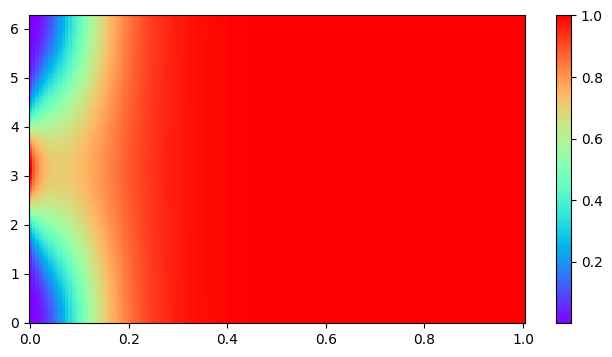

In [6]:
# plot color map of solution
plt.figure(figsize=(8, 4))
plt.pcolormesh(T, X, U, cmap='rainbow')
plt.colorbar()

# Custom Fit

In [7]:
backbone = create_dense_model([1000, 1000], activation='tanh', initializer='glorot_normal', \
    n_inputs=2, n_outputs=1)
reaction_f = ReactionDiffusionPinn.get_fishers_reaction_function(rho)
model = ReactionDiffusionPinn(backbone, nu, reaction_f) 
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.975)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
model.compile(optimizer=optimizer)

In [8]:
history = model.fit_custom(inputs, outputs, 50000, 2000-1)

2023-05-24 18:55:40.943004: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-24 18:55:40.955407: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f545006cc50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-24 18:55:40.955426: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-05-24 18:55:40.962529: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-24 18:55:41.157232: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-24 18:55:41.246229: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifeti

Epoch 0, Loss Residual: 18.5319, Loss Initial: 0.3710, Loss Boundary: 0.1140, MAE: 0.8545
Epoch 1999, Loss Residual: 2.9446, Loss Initial: 0.2437, Loss Boundary: 0.9695, MAE: 0.4226
Epoch 3998, Loss Residual: 1.1495, Loss Initial: 0.2808, Loss Boundary: 0.8481, MAE: 0.4155
Epoch 5997, Loss Residual: 0.3527, Loss Initial: 0.3203, Loss Boundary: 0.4771, MAE: 0.3647
Epoch 7996, Loss Residual: 0.0543, Loss Initial: 0.4215, Loss Boundary: 0.0911, MAE: 0.2978
Epoch 9995, Loss Residual: 0.0134, Loss Initial: 0.4263, Loss Boundary: 0.0355, MAE: 0.2753
Epoch 11994, Loss Residual: 0.0049, Loss Initial: 0.1106, Loss Boundary: 0.0001, MAE: 0.1308
Epoch 13993, Loss Residual: 0.0151, Loss Initial: 0.1027, Loss Boundary: 0.0000, MAE: 0.1322
Epoch 15992, Loss Residual: 0.0160, Loss Initial: 0.0869, Loss Boundary: 0.0019, MAE: 0.1240
Epoch 17991, Loss Residual: 0.0081, Loss Initial: 0.0490, Loss Boundary: 0.0008, MAE: 0.1200
Epoch 19990, Loss Residual: 0.0280, Loss Initial: 0.0401, Loss Boundary: 0.001

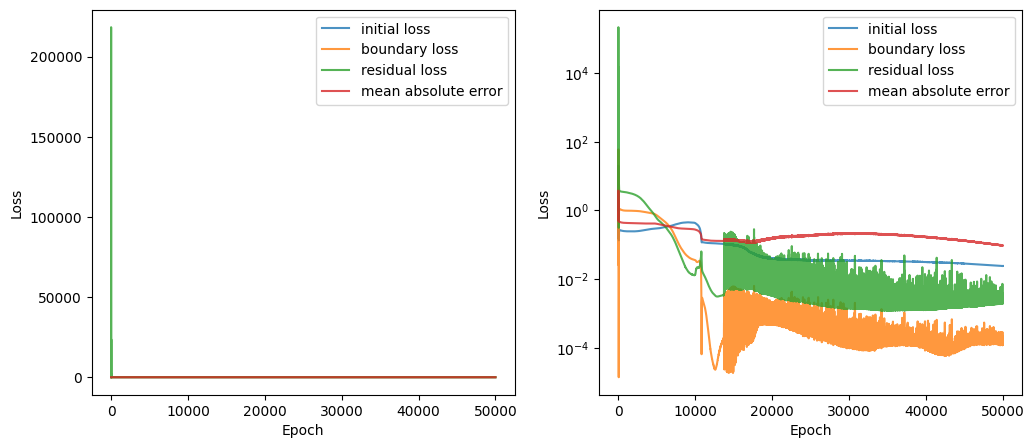

In [9]:
plot_training_loss_linlog(history)

1200/1200 [==============================] - 1s 482us/step


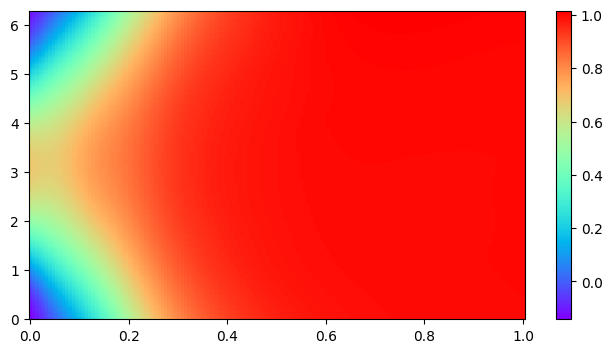

In [10]:
u_pred = backbone.predict(tf.concat([tf.reshape(T, (-1, 1)), tf.reshape(X, (-1, 1))], axis=1))
plt.figure(figsize=(8, 4))
plt.pcolormesh(T, X, tf.reshape(u_pred, T.shape), cmap='rainbow')
plt.colorbar()